In [1]:
import sys
sys.path.append('./BIC_codes/')
from functions.dFC_funcs import *
import numpy as np
import matplotlib.pyplot as plt
import hdf5storage
import scipy.io as sio
import os

Parameters

In [2]:
###### DATA PARAMETERS ######
DATA_type = 'sample' # 'sample' or 'Gordon' or 'simulated' or 'ICA'

num_subj = 2 # for Gordon/sample/ICA data
select_nodes = False # for Gordon data
rand_node_slct = False # for Gordon data
num_select_nodes = 50 # for Gordon data

output_root = './../../../RESULTs/methods_implementation/demo/'
data_root_sample = './sampleDATA/'
data_root_simul = './../../../DATA/TVB data/'
data_root_gordon = './../../../DATA/HCP/HCP_Gordon/'
data_root_ica = './../../../DATA/HCP/HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d50_ts2/'

###### MEASUREMENT PARAMETERS ######
n_states = 12
n_subj_clstrs = 16
n_hid_states = 6
n_overlap = 0.5
W_sw = 44 # in seconds
n_jobs = 4
n_jobs_methods = 2


Loading DATA

In [3]:
# FINDING SUBJECTs LIST

# ICA
ALL_RECORDS = os.listdir(data_root_ica)
ALL_RECORDS = [i for i in ALL_RECORDS if '.txt' in i]
ALL_RECORDS.sort()
SUBJECTS_ica = list()
for s in ALL_RECORDS:
    num = s[:s.find('.')]
    SUBJECTS_ica.append(num)
SUBJECTS_ica = list(set(SUBJECTS_ica))
SUBJECTS_ica.sort()

# GORDON
ALL_RECORDS = os.listdir(data_root_gordon)
ALL_RECORDS = [i for i in ALL_RECORDS if 'Rest' in i]
ALL_RECORDS.sort()
SUBJECTS_gordon = list()
for s in ALL_RECORDS:
    num = s[:s.find('_')]
    SUBJECTS_gordon.append(num)
SUBJECTS_gordon = list(set(SUBJECTS_gordon))
SUBJECTS_gordon.sort()

SUBJECTS = intersection(SUBJECTS_gordon, SUBJECTS_ica)

print( str(len(SUBJECTS)) + ' subjects were found. ' + str(num_subj) + ' subjects were selected.')

SUBJECTS = SUBJECTS[0:num_subj]

395 subjects were found. 5 subjects were selected.


In [4]:
if DATA_type=='ICA':

    BOLD = None
    for subject in SUBJECTS:
        time_series = np.loadtxt( \
            data_root_ica + subject + '.txt', dtype='float64' \
            )
        time_series = time_series.T
        
        # time_series = time_series - np.repeat(np.mean(time_series, axis=1)[:,None], time_series.shape[1], axis=1) # ???????????????????????

        if BOLD is None:
            BOLD = TIME_SERIES(data=time_series, subj_id=subject, Fs=1/0.72, TS_name='BOLD ICA')
        else:
            BOLD.append_ts(new_time_series=time_series, subj_id=subject)

    print(BOLD.n_regions, BOLD.n_time)

In [5]:
# HCP Data

if DATA_type=='Gordon':

    session = '_Rest1_LR'

    # LOAD Region Location DATA

    locs = sio.loadmat(data_root_gordon+'Gordon333_LOCS.mat')
    locs = locs['locs']

    # LOAD Region Data

    file = data_root_gordon+'Gordon333_Key.txt'
    f = open(file, 'r')

    atlas_data = []
    for line in f:
        row = line.split()
        atlas_data.append(row)

    BOLD = None
    for subject in SUBJECTS:

        subj_fldr = subject + session

        # LOAD BOLD Data

        DATA = hdf5storage.loadmat(data_root_gordon+subj_fldr+'/ROI_data_Gordon_333_surf.mat')
        time_series = DATA['ROI_data']

        time_series = time_series.T

        time_series = time_series - np.repeat(np.mean(time_series, axis=1)[:,None], time_series.shape[1], axis=1) # ???????????????????????

        if BOLD is None:
            BOLD = TIME_SERIES(data=time_series, subj_id=subject, Fs=1/0.72, locs=locs, nodes_info=atlas_data, TS_name='BOLD Real')
        else:
            BOLD.append_ts(new_time_series=time_series, subj_id=subject)

    print(BOLD.n_regions, BOLD.n_time)


    # select nodes

    if select_nodes:
        if rand_node_slct:
            nodes_idx = np.random.choice(range(BOLD.n_regions), size=num_select_nodes, replace=False)
            nodes_idx.sort()
        else:
            nodes_idx = np.array(list(range(47, 88)) + list(range(224, 263)))
        BOLD.select_nodes(nodes_idx=nodes_idx)

    print(BOLD.n_regions, BOLD.n_time)


In [6]:
if DATA_type=='sample':

    ###### BOLD DATA ######
    time_BOLD = np.load(data_root_sample+'bold_time.npy')/1e3    
    time_series = np.load(data_root_sample+'bold_data.npy')

    time_series = time_series.T

    BOLD = None
    for subject in range(5):

        if BOLD is None:
            BOLD = TIME_SERIES( \
                data=time_series[:, (subject)*1200:(subject+1)*1200], \
                subj_id=str(subject+1), Fs=1/0.5, \
                time_array=time_BOLD[(subject)*1200:(subject+1)*1200], \
                TS_name='BOLD Sample' \
                )
        else:
            BOLD.append_ts( \
                new_time_series=time_series[:, (subject)*1200:(subject+1)*1200], \
                time_array=time_BOLD[(subject)*1200:(subject+1)*1200],
                subj_id=str(subject+1) \
                )

    print(BOLD.n_regions, BOLD.n_time)
        

76 6000


In [7]:
if DATA_type=='simulated':

    ###### BOLD DATA ######
    time_BOLD = np.load(data_root_simul+'bold_time.npy')/1e3    
    time_series_BOLD = np.load(data_root_simul+'bold_data.npy')

    BOLD = TIME_SERIES(data=time_series_BOLD.T, subj_id='1', Fs=1/0.5, time_array=time_BOLD, TS_name='BOLD Simulation')

    ###### TAVG DATA ######
    time_Tavg = np.load(data_root_simul+'TVB data/tavg_time.npy')/1e3    
    time_series_Tavg = np.load(data_root_simul+'TVB data/tavg_data.npy')

    TAVG = TIME_SERIES(data=time_series_Tavg.T, subj_id='1', Fs=200, time_array=time_Tavg, TS_name='Tavg Simulation')

Visualizing Time Series Data

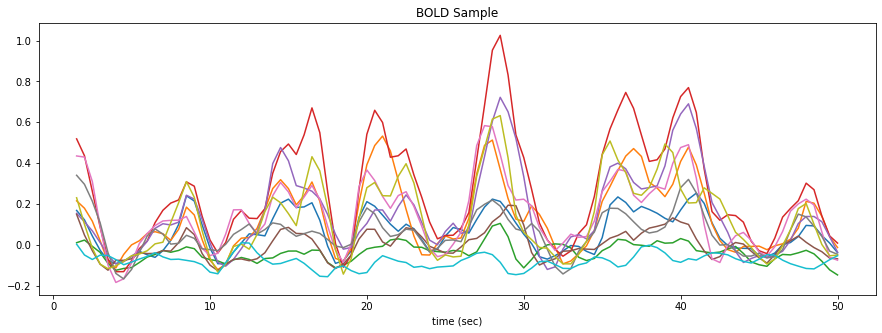

In [8]:
BOLD.visualize(start_time=0, end_time=50, nodes_lst=list(range(10)))

# BOLD.truncate(start_point=None, end_point=1200)  

Measuring dFC using Sliding Window as Data-driven method for a single subject

In [9]:
params = {'W': int(W_sw*BOLD.Fs), 'n_overlap': n_overlap}

sw = SLIDING_WINDOW(sw_method='MI', **params)

In [10]:
subj_id = np.unique(BOLD.subj_id_array)[0]
print('Sliding Window Measurement for subject ' + subj_id)
print("dFCM estimation started...")
dFCM = sw.estimate_dFCM(time_series=BOLD.get_subj_ts(subj_id=subj_id))
print("dFCM estimation done.")

Sliding Window Measurement for subject 1
dFCM estimation started...
dFCM estimation done.


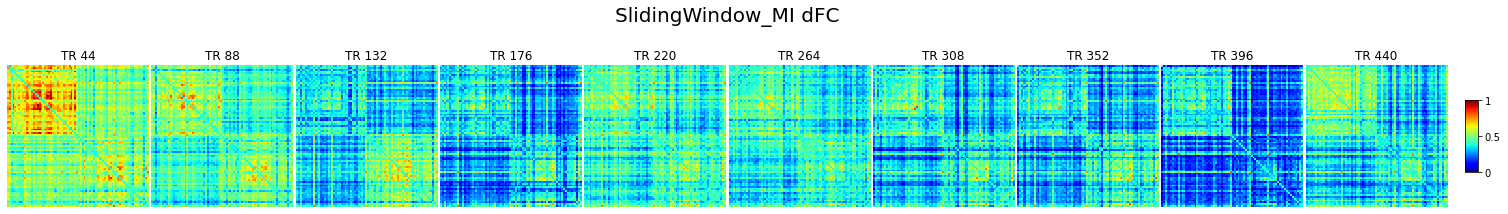

In [11]:
TRs = dFCM.TR_array[:10]
dFCM.visualize_dFC(TRs=TRs, normalize=True, threshold=0.0, fix_lim=True)

Measuring dFC using Continuous HMM as a state-based method for multiple subjects

In [12]:
params = {'n_states': n_states}

hmm_cont = HMM_CONT(**params)

In [13]:
print("FCS estimation started...")
hmm_cont.estimate_FCS(time_series=BOLD)
print("FCS estimation done.")

print("dFCM estimation started...")
dFCM = hmm_cont.estimate_dFCM(time_series=BOLD)
print("dFCM estimation done.")

FCS estimation started...
FCS estimation done.
dFCM estimation started...
dFCM estimation done.


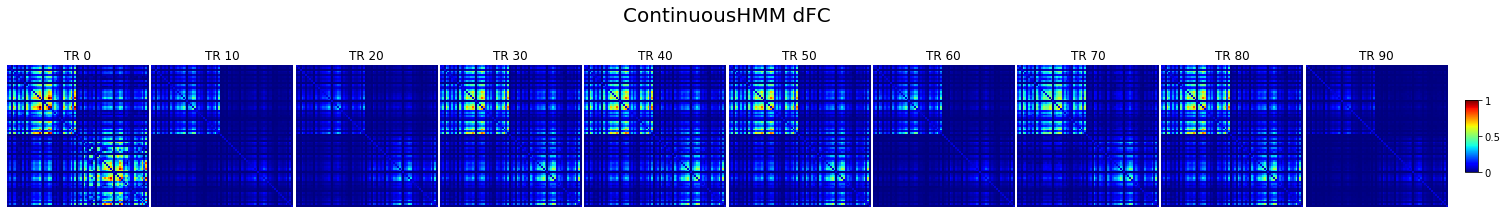

In [14]:
TRs = dFCM.TR_array[:100:10]
dFCM.visualize_dFC(TRs=TRs, normalize=True, threshold=0.0, fix_lim=True)

Analyzing Multiple dFC Methods

In [15]:
BOLD.truncate(start_point=None, end_point=None) 

In [16]:
params = { \
    # Sliding Parameters
    'W': int(W_sw*BOLD.Fs), 'n_overlap': n_overlap, \
    # State Parameters
    'n_states': n_states, 'n_subj_clstrs': n_subj_clstrs, 'n_hid_states': n_hid_states, \
    # Parallelization Parameters
    'n_jobs': n_jobs_methods, 'verbose': 0, 'backend': 'loky' \
        }

###### CONTINUOUS HMM ######
hmm_cont = HMM_CONT(**params)

###### WINDOW_LESS ######
windowless = WINDOWLESS(**params)

###### SLIDING WINDOW ######
sw_pc = SLIDING_WINDOW(sw_method='pear_corr', **params)
sw_mi = SLIDING_WINDOW(sw_method='MI', **params)

###### TIME FREQUENCY ######
time_freq_cwt = TIME_FREQ(method='CWT_mag', **params)
time_freq_wtc = TIME_FREQ(method='WTC', **params)

###### SLIDING WINDOW + CLUSTERING ######
swc_pc = SLIDING_WINDOW_CLUSTR(base_method='pear_corr', **params)

###### DISCRETE HMM ######
hmm_disc_pc = HMM_DISC(base_method='pear_corr', **params)

MEASURES = [
    hmm_cont, \
    windowless, \
    sw_pc, \
    sw_mi, \
    time_freq_cwt, \
    time_freq_wtc, \
    swc_pc, \
    hmm_disc_pc,\
            ]
        

dFC Analyzer

In [17]:
dFC_analyzer = DFC_ANALYZER(MEASURES_lst = MEASURES, vis_TR_idx=list(range(10, 20, 1)), \
    save_image=True, output_root=output_root,
    n_jobs=n_jobs, verbose=1, backend='loky' \
    )

In [18]:
subj_id = np.unique(BOLD.subj_id_array)[0]
print('Time Analysis for subject ' + subj_id)
dFC_analyzer.time_analyze(time_series=BOLD.get_subj_ts(subj_id=subj_id))

Time Analysis for subject 1


Fitting a model with 101 free scalar parameters with only 26 data points will result in a degenerate solution.


Measure ContinuousHMM time = 26.65628981590271 = 26.646322011947632 + 0.009967803955078125
Measure Windowless time = 0.6116271018981934 = 0.5500543117523193 + 0.06157279014587402
Measure SlidingWindow_pear_corr time = 7.383644104003906
Measure SlidingWindow_MI time = 44.34035038948059
Measure Time-Frequency _CWT_mag time = 40.11797571182251
Measure Time-Frequency _WTC time = 165.40966415405273
Measure SlidingWindow+Clustering_pear_corr time = 22.82248878479004 = 15.66919493675232 + 7.15329384803772
Measure DiscreteHMM_pear_corr time = 30.804265022277832 = 23.34017515182495 + 7.464089870452881


In [19]:
dFC_analyzer.analyze(time_series=BOLD)

FCS estimation started...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.3min remaining:  2.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  3.6min finished


FCS estimation done.
dFCM estimation started...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 18.1min finished


dFCM estimation done.
